<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3.%20Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3a. Baseline Model – TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;">TF-IDF vectorization + logistic regression as a benchmark.</p>
</div>


## Baseline Sentiment Classifier: TF-IDF + Logistic Regression

This notebook implements the **baseline model** for our tweet sentiment classification project, using a combination of **TF-IDF vectorization** and **Logistic Regression**.

### Why TF-IDF + Logistic Regression?

- **TF-IDF** transforms raw tweet text into numerical feature vectors by measuring the importance of words relative to the entire corpus.
- **Logistic Regression** is a simple yet effective linear classifier that provides strong performance with fast training time and easy interpretability.

TF-IDF is ideal for linear models but sensitive to document length. To prevent longer tweets from biasing the model, we apply **L2 normalization**, ensuring each tweet contributes equally regardless of length.

### What This Notebook Covers

- Loads preprocessed training and validation data
- Tokenizes and normalizes text using Gensim and TF-IDF
- Tunes hyperparameters using `GridSearchCV`
- Trains a logistic regression model on vectorized tweets
- Evaluates performance on the validation set using accuracy, precision, recall, F1 score, and a confusion matrix
- Saves the trained pipeline for reuse in evaluation

This baseline serves as a reference point for evaluating deeper models like LSTM and BERT, helping us assess whether the added complexity improves sentiment classification.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"

In [3]:
train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"

In [4]:
import sys
!{sys.executable} -m pip install -r "{PROJECT_ROOT}/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.7 MB/s eta 0:00:00


In [5]:
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [6]:
# Import helper functions
sys.path.append(f"{PROJECT_ROOT}/utils")
from helper import load_clean_train_val_datasets

In [7]:
train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

In [8]:
train_df.head()

,text,target
0,doesnt know hahahahahaha hi world twitter,4
1,gahh im hungryy shouldve something teadinner s...,0
2,last day,0
3,sunburn forget put sunblock shnatzi,0
4,usermention want go home contact hurt,0


In [9]:
val_df.head()

,text,target
0,lng fn day mah head killin im tire den bih bt ...,0
1,usermention nah manthat fit lmao run mix oh ma...,4
2,usermention kno right thermostat war almost al...,0
3,usermention awww well dont worry youre miss mu...,0
4,use little girls room soo bad soon leave bos c...,0


#### Observation: Dataset Inspection and Language Quality

After loading the dataset, we inspect the first few rows using `head()`. The `text` column contains raw tweets, which often include:

* Informal language and slang (e.g., "lmao", "bt", "nah manthat")
* Typos, abbreviations, and creative spellings
* Phonetic spellings or dialect-specific phrasing
* Hashtags, emojis, or special characters
* Occasionally, non-English or mixed-language content

This is **expected behavior** for the Sentiment140 dataset, which was collected from Twitter and reflects real-world, noisy text data.

While most tweets are in English or English-based internet slang, it's possible that some non-English tweets are present. For now, we retain this noise to maintain the dataset's realism, which helps models generalize to real-world social media inputs.

In [10]:
# next, we extract targets

# Ensure 'target' is int and remap 4 → 1
X_train = train_df['text'].astype(str)
y_train = train_df['target'].astype(int).replace({4: 1})

X_val = val_df['text'].astype(str)
y_val = val_df['target'].astype(int).replace({4: 1})


# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)

Train shape: (1119609, 2)
Validation shape: (239917, 2)
X_train shape: (1119609,) | y_train shape: (1119609,)
X_val shape: (239917,) | y_val shape: (239917,)


### Why Use TF-IDF Instead of Word Embeddings?

Here, we use **TF-IDF vectorization** in combination with **Logistic Regression** to build a baseline sentiment classifier. A natural question is: _Why not use word embeddings like Word2Vec, GloVe, or BERT instead of TF-IDF?_ Here's why:

#### TF-IDF is Simple and Effective for Linear Models
TF-IDF (Term Frequency–Inverse Document Frequency) transforms text into sparse vectors that indicate the relative importance of each word in the tweet. This is ideal for traditional linear models like Logistic Regression, which rely on **high-dimensional but interpretable** feature inputs.

#### Embeddings Require Context-Aware Models
Word embeddings (like Word2Vec or BERT) encode semantic similarity — which is powerful — but they are designed to be used with **neural network models** like LSTMs or Transformers. These models can learn complex patterns in dense embeddings, while Logistic Regression cannot exploit such structure effectively.

#### Interpretable and Lightweight
TF-IDF allows us to inspect which words are influential for predictions by analyzing model coefficients. This interpretability is important in early stages and baselines. Additionally, it's **faster to compute** and doesn't rely on external pretrained models.

### Logistic Regression with TF-IDF: Why Normalization is Essential

In this notebook, we use `TfidfVectorizer` to transform tweets into numerical vectors before training a Logistic Regression classifier for sentiment prediction.

However, tweets can vary widely in length — some are just a few words, while others are long sentences. If we don't normalize the TF-IDF vectors, longer tweets may end up with higher total values simply because they contain more words. This can unintentionally bias the classifier to favor longer inputs.

To address this, we apply **L2 normalization** to all TF-IDF vectors. This ensures that every tweet, regardless of length, contributes equally to the model — and the prediction depends more on the **pattern of word importance** rather than the **number of words**.

By default, `TfidfVectorizer(norm='l2')` handles this for us, making our input vectors have unit length and preventing length-based skew in model training.

In [11]:
# Then, we define pipeline combining TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        norm='l2'
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])

### Hyperparameter Tuning

Here, we apply **GridSearchCV** to optimize the hyperparameters of our TF-IDF + Logistic Regression pipeline.

#### What is GridSearchCV?

`GridSearchCV` is a tool in scikit-learn that automates hyperparameter tuning. Instead of manually guessing the best values for model settings (like regularization strength or n-gram range), GridSearchCV systematically tries out all combinations of parameters in a defined grid and evaluates them using cross-validation.

#### Why It Matters:

Different parameter settings can dramatically affect model performance. For example:
- A **high regularization (C)** might underfit the data
- A **broad n-gram range** might capture more context, or lead to overfitting
- Filtering out common/rare words using **`max_df`** and **`min_df`** can improve generalization

By evaluating each configuration using **3-fold cross-validation**, we get a reliable estimate of how each setting performs across the data.

#### What We Tuned:
- **TF-IDF vectorizer**:
  - `max_features`, `ngram_range`, `min_df`, `max_df`
- **Logistic Regression**:
  - `C` (regularization), `penalty`, `class_weight`

The best combination is selected based on **weighted F1 score**, which balances precision and recall in the presence of class imbalance.

In [12]:
# Then, we define parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
    'tfidf__max_df': [0.7, 0.9],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],  # 'l1' requires solver='liblinear'
    'clf__class_weight': [None, 'balanced']
}

# Setup GridSearchCV with 3-fold CV and weighted F1
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

# Perform grid search
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Extract best model from grid search
best_model = grid_search.best_estimator_

# Show best parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)

Starting hyperparameter tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best Parameters Found:
{'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


### Best Hyperparameters Summary

After performing GridSearchCV with 3-fold cross-validation across 96 parameter combinations, the following configuration achieved the best weighted F1-score on the validation data:

```python
Best Parameters Found:
{
    'clf__C': 1,
    'clf__class_weight': None,
    'clf__penalty': 'l2',
    'tfidf__max_df': 0.7,
    'tfidf__max_features': 10000,
    'tfidf__min_df': 1,
    'tfidf__ngram_range': (1, 2)
}
````

#### What These Mean:

* **`clf__C=1`**: This is the inverse of regularization strength. A value of 1 means moderate regularization — not too strict, not too loose.
* **`clf__class_weight=None`**: No adjustment for class imbalance was needed — consistent with the class distribution being fairly balanced in our dataset.
* **`clf__penalty='l2'`**: L2 regularization (ridge-style) was used, which penalizes large coefficients and helps reduce overfitting.
* **`tfidf__max_df=0.7`**: Words appearing in more than 70% of tweets were excluded. This removes very common words that do not help differentiate sentiment.
* **`tfidf__max_features=10000`**: The feature space is limited to the 10,000 most important terms based on TF-IDF scores. This balances performance and memory efficiency.
* **`tfidf__min_df=1`**: Very rare words (appearing in just one tweet) were included. In this dataset, such rare terms may carry meaningful sentiment signals (e.g., slang, hashtags).
* **`tfidf__ngram_range=(1, 2)`**: Both unigrams (single words) and bigrams (pairs of consecutive words) were used. This captures more contextual meaning than unigrams alone.

This configuration balances expressiveness (via bigrams and rare words) with robustness (via regularization and feature limits). It serves as our final optimized model for TF-IDF + Logistic Regression.

In [13]:
# Then, we train our Logistic Regression Model

# The best model from GridSearchCV is already trained
TFIDF_LogReg_model = best_model

# Save the trained pipeline (TF-IDF + Logistic Regression)
joblib.dump(TFIDF_LogReg_model, f"{PROJECT_ROOT}/models/tfidf_logreg_pipeline.joblib")
print("Model saved to tfidf_logreg_pipeline.joblib")

Model saved to tfidf_logreg_pipeline.joblib


### Interpreting Model Coefficients — Most Influential Words

One of the key advantages of using a linear model like Logistic Regression is interpretability. Each word (or n-gram) in the TF-IDF feature space is assigned a coefficient that reflects its contribution to the model's prediction.

- A **positive coefficient** indicates that the word pushes the model toward predicting **positive sentiment**.
- A **negative coefficient** suggests that the word is associated with **negative sentiment**.

By examining the most strongly weighted words, we can better understand the linguistic patterns the model has learned.

In the plots below, we visualize the **top 10 positive and negative sentiment words** based on their model weights. This helps validate the model's behavior and provides intuitive insight into how different words influence predictions.


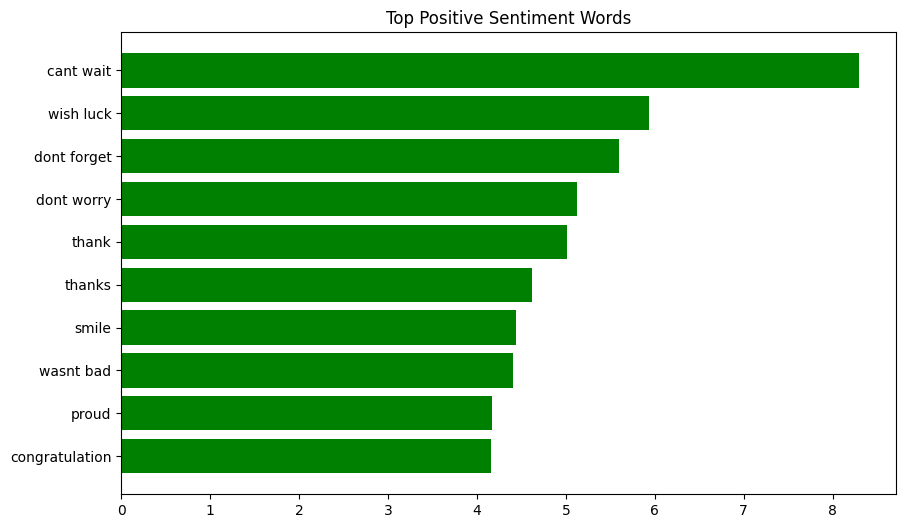

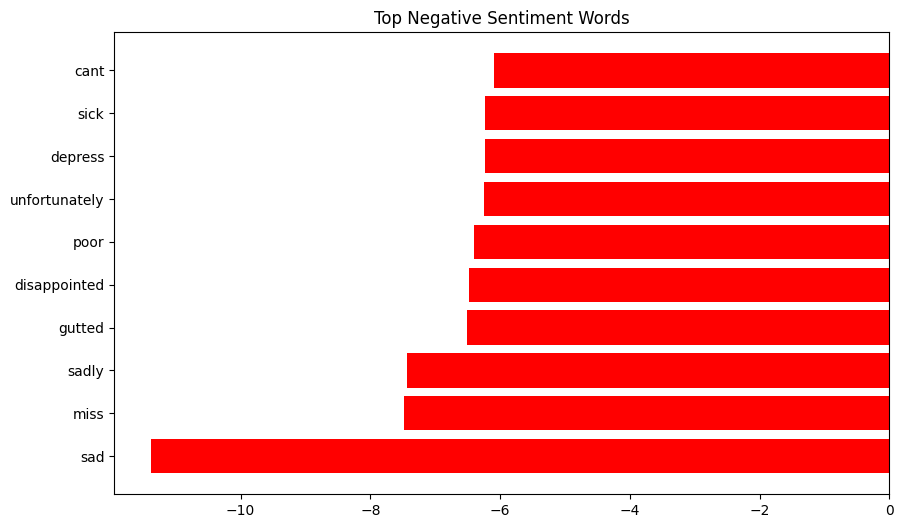

In [14]:
# Get the vectorizer and classifier from the pipeline
vectorizer = TFIDF_LogReg_model.named_steps['tfidf']
classifier = TFIDF_LogReg_model.named_steps['clf']

# Get feature names and coefficients
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = classifier.coef_[0]

# Top positive and negative words
top_pos_indices = np.argsort(coefficients)[-10:]
top_neg_indices = np.argsort(coefficients)[:10]

top_pos_words = feature_names[top_pos_indices]
top_neg_words = feature_names[top_neg_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_pos_words, coefficients[top_pos_indices], color='green')
plt.title("Top Positive Sentiment Words")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_neg_words, coefficients[top_neg_indices], color='red')
plt.title("Top Negative Sentiment Words")
plt.show()

### Confusion Matrix

The confusion matrix below summarizes the model’s performance on the test set by showing the count of correct and incorrect predictions across sentiment classes.

This serves as a baseline reference for evaluating future models. We will revisit this matrix when comparing results from deep learning approaches in other notebooks.

In [15]:
# Then we evaluate the Model

# Predict on validation set
y_val_pred = TFIDF_LogReg_model.predict(X_val)

# Compute metrics
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

# Print summary
print("\n--- Validation Performance (Logistic Regression) ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


--- Validation Performance (Logistic Regression) ---
Accuracy:  0.7816
Precision: 0.7700
Recall:    0.8032
F1 Score:  0.7862


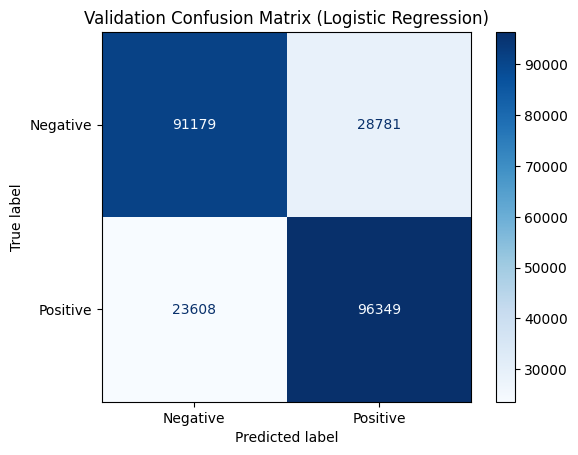

In [16]:
# Next, we view the confusion matrix

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Validation Confusion Matrix (Logistic Regression)")
plt.grid(False)
plt.show()

### Understanding Where the Model Fails

While the baseline model achieves a respectable F1-score of near 0.8, aggregate metrics alone can mask important patterns. Not all errors are equal — some reflect deeper issues in how the model interprets language.

To uncover these issues, we take a closer look at the tweets that were misclassified with high confidence. These examples help surface specific linguistic challenges the model struggles with, providing insights that metrics like accuracy or F1 cannot reveal.


In [17]:
# --- Error Analysis ---

# Get prediction probabilities for the validation set
# The probability for the predicted class is the confidence score.
y_proba = TFIDF_LogReg_model.predict_proba(X_val)

# Build the error analysis DataFrame
# This combines the original text, true labels, predictions, and confidence.
errors_df = pd.DataFrame({
    'text': X_val,
    'true_label': y_val,
    'predicted_label': y_val_pred,
    'confidence': y_proba.max(axis=1) # Get the highest probability as the confidence score
})

# Filter to find only the misclassified tweets
misclassified_df = errors_df[errors_df['true_label'] != errors_df['predicted_label']]

# Sort the misclassified tweets by confidence in descending order
# This shows the errors the model was "most confident" about, which are often the most insightful.
most_confident_errors = misclassified_df.sort_values(by='confidence', ascending=False)

# Display the top 10 most confident errors
print("Top 10 Most Confident Misclassifications:")
# Set display options to prevent wrapping
pd.set_option('display.max_colwidth', 200) # To see the full tweet text
pd.set_option('display.width', 1000) # Increase display width to prevent line breaks
print(most_confident_errors.head(10))

Top 10 Most Confident Misclassifications:
                                                         text  true_label  predicted_label  confidence
228304                   usermention dont sad doesnt make sad           1                0    0.999687
184485                   usermention filthy mcnasty cant hate           1                0    0.999338
187310  usermention yeah flu suck hate fever couldnt anything           1                0    0.999263
73838                                                miss opc           1                0    0.999261
129775                                               miss beb           1                0    0.999261
236381                                                   miss           1                0    0.999261
100159                           cb miss puthars hifi biryani           1                0    0.999261
211943                                                   miss           1                0    0.999261
216924                         

### Error Analysis: Insights from Misclassified Tweets

While the baseline F1-score is respectable, near 0.8, error analysis on the most confidently misclassified tweets reveals systemic weaknesses that aggregate metrics hide. The error analysis shows a clear pattern of positive tweets being misclassified as negative, leading to several key observations.

#### Key Observations:

- **Context and Negation Blindness**:  
  The model is easily swayed by words with strong negative associations ("sad," "hate"), failing to interpret surrounding context like negation ("cant hate"). This is a classic limitation of TF-IDF's "bag-of-words" approach, which ignores word order.

- **Misinterpreting Ambiguous Words**:  
  The model systematically misclassifies the word "miss." Having learned it as a strong negative indicator, it incorrectly flags any tweet containing the word, unable to differentiate its contextual meaning. Note that these are unique tweets, not duplicates, highlighting a significant model flaw.

These findings underscore the baseline model's limitations in understanding linguistic nuance. Its inability to handle sarcasm, negation, and context provides a strong justification for using more sophisticated, context-aware architectures like LSTMs and Transformers.


> **Note:** One might consider deduplicating tweets that contain repeated patterns like the word *“miss”* to reduce bias in error analysis. However, in this case, these are **distinct tweets** from different users or contexts that happen to share the same word. Removing them would obscure a real modeling issue: the model is overfitting to surface-level word cues without understanding context. Keeping these examples highlights a consistent failure mode and strengthens the case for using context-aware models.

## Wrap-Up: Strengths and Limitations of Logistic Regression

In our baseline notebook, we identify that Logistic Regression paired with TF-IDF provides a solid and interpretable baseline for sentiment classification. It has strengths and limitations:

#### Strengths
- **Fast and efficient**: Trains quickly and scales well to large datasets.
- **Interpretable**: Coefficients reveal which words drive sentiment predictions.
- **Simple to implement**: Easy to set up and tune with standard tools like scikit-learn.
- **Lightweight**: Requires minimal computational resources.
- **Strong baseline**: Performs surprisingly well given its simplicity.

#### Limitations
- **Context-insensitive**: Ignores word order, making it blind to negation or sarcasm.
- **Bag-of-words rigidity**: Cannot capture deep semantic relationships between words.
- **Over-reliance on keywords**: Heavily influenced by individual terms without understanding their context.
- **Struggles with nuance**: Misclassifies tweets containing ambiguous or sentiment-shifting phrases (e.g., "miss", "can't hate").

These limitations highlight the need for more context-aware architectures — such as LSTMs and Transformers — which can better capture the complexity and nuance of natural language.